In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid, imshow_grid
from landlab.components import TidalFlowCalculator
from landlab.grid.mappers import map_mean_of_link_nodes_to_link,  map_link_vector_components_to_node
from landlab.io import read_esri_ascii
import tidal_erosion_calculator as tec

In [2]:
# Set parameters (these are from the MarshMorpho2D source code)
tidal_period = 12.5 * 3600.0  # tidal period in seconds
tidal_range = 3.1  # tidal range in meters
roughness_w = 0.02  # Manning's n water
roughness_v = 0.1 #manning's n for veg
mean_sea_level = 0.0  # mean sea level in meters
mwd = 0.01  # minimum depth for water on areas higher than low tide water surface, meters
nodata_code = 999  # code for a DEM cell with no valid data
tcrgradeint = 0.2; # linear increase in tcr below MLW [pa/m
# Read the DEM to create a grid and topography field
(grid, z) = read_esri_ascii('zSW3.asc', name='topographic__elevation')

#need to create vegetation grid #change to veg at cells
veg = grid.add_zeros('vegetation',at='node');
veg[z<0] = 1; #vegetation placed on all "land cells" - change as desired
veg_atlink = grid.map_max_of_link_nodes_to_link('vegetation')
grid.add_field('veg_atlink',veg_atlink,at='link')

# Configure boundaries: any nodata nodes, plus any nodes higher than mean high tide
grid.status_at_node[z==nodata_code] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[z>1.8] = grid.BC_NODE_IS_CLOSED
boundaries_above_msl = np.logical_and(grid.status_at_node==grid.BC_NODE_IS_FIXED_VALUE, z > 0.0)
grid.status_at_node[boundaries_above_msl] = grid.BC_NODE_IS_CLOSED

print('pre tfc:')
print(grid.at_node.keys())
print(grid.at_link.keys())

#variable rougness as field in grid
roughness_at_nodes = roughness_w + np.zeros(z.size)
roughness_at_nodes[z < 0.0] = roughness_v #or roughness_at_nodes[veg] = roughness_v
roughness = grid.add_zeros('roughness', at='link')
map_mean_of_link_nodes_to_link(grid, roughness_at_nodes, out=roughness)

# Instantiate a TidalFlowCalculator component
tfc = TidalFlowCalculator(
        grid,
        tidal_period=tidal_period,
        tidal_range=tidal_range,
        roughness='roughness',
        mean_sea_level=mean_sea_level,
        min_water_depth=mwd,
)
tfc.run_one_step()
print(grid.at_node.keys())

pre tfc:
['topographic__elevation', 'vegetation']
['veg_atlink']
['topographic__elevation', 'vegetation', 'mean_water__depth']


In [3]:
tau_cr = 0.2 #Critical stress for unvegetated areas
tau_crv = 0.5  #Critical stress for vegetated areas
mud_erodability = (10**-5);  # mud erodability kg/m2/s

v = grid.at_link['veg_atlink']
#populate grids to use in erosion calculations
tec.populateGrids(grid,tfc,tau_cr,tau_crv,v)

In [4]:
#run a single erosion step (note this just calculate erosion as a rate, does not update grids)
ero = tec.totalsedimenterosion_mudsine(grid, mud_erodability, tidal_range, tcrgradeint)
print(ero)
print(ero.mean())

[ 0.  0.  0. ...,  0.  0.  0.]
6.93784269471e-06


In [5]:
#save original bathy & topo maps
x = grid.at_node['topographic__elevation'].copy()
grid.add_field('Initial_topographic_elevation',x,at='node')
y = grid.at_node['mean_water__depth'].copy()
grid.add_field('Initial_mean_water_depth',y,at='node')

array([ 0.01,  0.01,  0.01, ...,  0.01,  0.01,  0.01])

z min post erosion: -2.6107306277
z min post erosion: -2.61209543996
z min post erosion: -2.61344179318
z min post erosion: -2.61477001126
z min post erosion: -2.61608040166
z min post erosion: -2.61737325834
z min post erosion: -2.61864885718
z min post erosion: -2.61990747398
z min post erosion: -2.6211493718
z min post erosion: -2.62237481337
z min post erosion: -2.62358404994
z min post erosion: -2.62477730751
z min post erosion: -2.62595479776
z min post erosion: -2.62711673619
z min post erosion: -2.62826334025
z min post erosion: -2.62939481976
z min post erosion: -2.63051138687
z min post erosion: -2.63161324213
z min post erosion: -2.63270058052
z min post erosion: -2.6337736019
z min post erosion: -2.63483249176
z min post erosion: -2.63587743584
z min post erosion: -2.63690861225
z min post erosion: -2.63792619477
z min post erosion: -2.63893035574
z min post erosion: -2.63992126435
z min post erosion: -2.64089910207
z min post erosion: -2.64186404423
z min post erosion: -2.

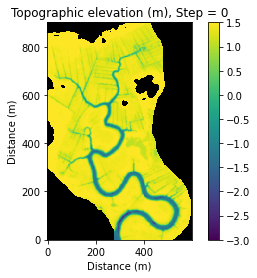

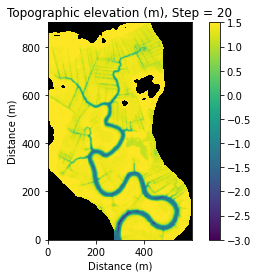

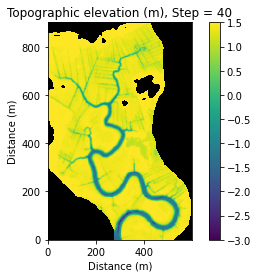

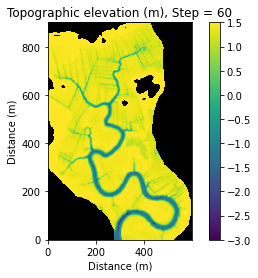

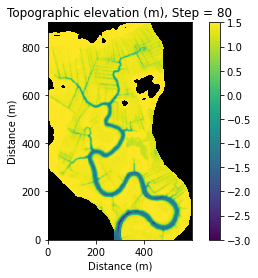

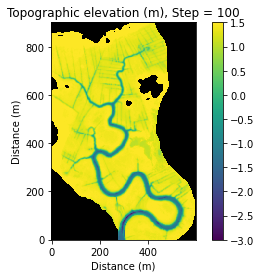

In [6]:
#now to actually do psuedo morphodynamics (aka allow erosion to happen in cells, but no sed. transport, no deposition)
#this will step through erosion calculation, calculate the new bed elevation, recalculate the hydrodynamics, and update grids
#it then plots every 20th  step, and outputs the minimum bed elevation every step

for i in range(101):
    ero = tec.totalsedimenterosion_mudsine(grid, mud_erodability, tidal_range, tcrgradeint)
    ero *= tidal_period/2 * 1/2650 #calc erosion over half the tidal cycle converting
    #ero *= 1/1025 #if using mud erodability in days (unsure of how that works unit wise)
    #print('ero mean: ' + str(ero.mean()))
    #print('ero max: ' +str(ero.max()))
    #print('z min: ' +str(z.min()))
    z = grid.at_node['topographic__elevation']
    z -= ero #update bed elevation
    print('z min post erosion: ' +str(z.min()))
    tfc.run_one_step()
    tec.updategrids(grid,tfc)  
    
    if i%20==0:
        plt.figure()
        imshow_grid(grid,grid.at_node['topographic__elevation'], vmin = -3, vmax = 1.5, cmap = 'viridis')
        plt.title('Topographic elevation (m), Step = ' + str(i))
        plt.xlabel('Distance (m)')
        plt.ylabel('Distance (m)')
    

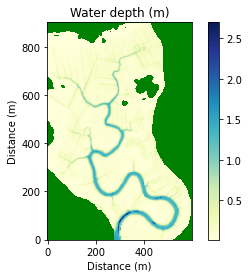

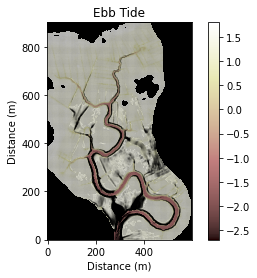

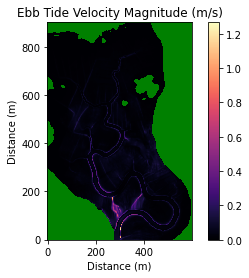

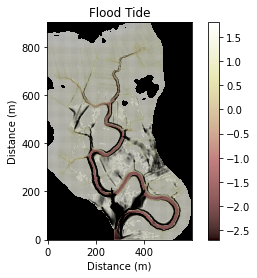

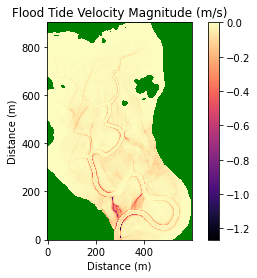

In [7]:
tec.plot_tidal_flow(grid) #plot the various flow mechanisms

Text(0, 0.5, 'Distance (m)')

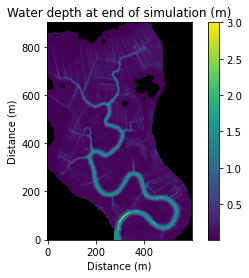

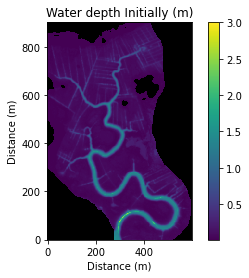

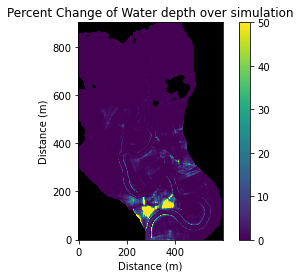

In [14]:
#plot final water depths
plt.figure()
imshow_grid(grid, grid.at_node['mean_water__depth'], cmap='viridis', color_for_closed='k',vmax=3)
plt.title('Water depth at end of simulation (m)')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')

plt.figure()
imshow_grid(grid, grid.at_node['Initial_mean_water_depth'], cmap='viridis', color_for_closed='k',vmax=3)
plt.title('Water depth Initially (m)')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')

plt.figure()
g =  grid.at_node['mean_water__depth'].copy();
go = grid.at_node['Initial_mean_water_depth'].copy();
gper = (g-go)/go * 100
grid.add_field('Percent Change water depth',gper,at='node',clobber=True)
imshow_grid(grid, grid.at_node['Percent Change water depth'], cmap='viridis', color_for_closed='k',vmax=25)
plt.title('Percent Change of Water depth over simulation')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')